In [3]:
import pandas as pd
import stanza
import string
import time
import re
import nltk
import numpy as np

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from gensim import corpora, models
from gensim.models import  Word2Vec
import gensim
import numpy as np
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from matplotlib import cm 
from gensim.utils import simple_preprocess
import pyLDAvis
from pyLDAvis import gensim_models
from gensim.models.ldamodel import LdaModel
import logging
from gensim.test.utils import datapath
    
import nltk
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
def format_topics_sentences(ldamodel, corpus, texts):
    sent_topics_df = pd.DataFrame()

    i=0
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

def top_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids if row[i]>0]
    df = pd.DataFrame(top_feats)
    if len(top_feats) > 0:
        df.columns = ['feature', 'score']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_feats(row, features, top_n)

def get_law(xpo2, dat, nbdoc):

    count = 0
    tmp = {}
    
    for i in range(len(xpo2)):
        for y in range(len(xpo2.iloc[i])):
            if xpo2.iloc[i,y] is np.nan:
                break
            else:
                tmp[count] = i
                count +=1
#    print(tmp)
    
    return(tmp[nbdoc])

def initialisation():
    
    ### IMPORTS

        # CF AU DESSUS
    
    ### STOPWORDS
    
    with open("./stopwords/Stop-words-french.txt", "r", encoding='utf8') as f:
        stopW1 = [line.rstrip("\n") for line in f.readlines()]
    with open("./stopwords/stopword.txt", "r", encoding='utf8') as f:
        stopW2 = [line.rstrip("\n") for line in f.readlines()]
    with open("./stopwords/stopwords_topics.txt", "r", encoding='utf8') as f:
        stopW3 = [line.rstrip("\n") for line in f.readlines()]
    stopW = stopW1 + stopW2 + stopW3 #+ stopwords.words("french")
    stopW.extend(string.punctuation)
    stopW.extend(['’', '«', '»', '…', '—','».', '»,', '---', '.—', '…—', 'ans', 'an'])
    
    ### IMPORT TABLEAU
    
    xpo2 = pd.read_excel("./Exports/sentences_lemma.xlsx", index_col=0)

    i, j = xpo2.shape
    print(i, j)

    for x in range(i):
        for y in range(j):
            if pd.isna(xpo2[y][x]) == True:
                continue
            else:
                sent = xpo2[y][x]
                sent = ''.join(sent)

                sent = re.sub('\'', '', sent)
                sent = re.sub('\]', '', sent)
                sent = re.sub('\[', '', sent)

                sent = sent.split(', ')
                xpo2[y][x] = sent

    ### NETTOYAGE DONNEES
    
    dat = [x for i in xpo2.index for x in xpo2.iloc[i] if x is not np.nan]
    for i in range(len(dat)):
#        print(dat[i])
        sent = re.sub(r'[^A-Za-zÀ-ÿ-’\' ]+', '', ' '.join(dat[i]))
        sent = nltk.word_tokenize(sent)
        stop_doc = [word for word in sent if word not in stopW]
        dat[i] = stop_doc
    
    ### PREPRA LDA
    
    data = dat

        # création du dictionnaire
    dico = corpora.Dictionary(data)

        # ce qui permet par ex. de filtrer le vocabulaire
    dico.filter_extremes(no_below=10)

        # Create Corpus
    texts = data

        # matrice Term Document Frequency
    corpus = [dico.doc2bow(text) for text in texts]
    
    ### LDA
    
    ntopics = 20
    
    generate_lda = False  # FALSE POUR LOADER LE FICHIER DE NOS THEMATIQUES

    if generate_lda:
        print("generate new LDA model")
        logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
        ldamodel = LdaModel(corpus, num_topics=ntopics, id2word = dico,
                                           passes=2, random_state=100, per_word_topics=True)
        print(ldamodel)

    temp_file = datapath("model20_lemma2") #"model20_lemma"

    if generate_lda:
        ldamodel.save(temp_file)
    else:
        ldamodel = LdaModel.load(temp_file) 
        print('loaded')
        
        
    ### TABLEAU DES TOPICS
    
    ldc = ldamodel[corpus]

        # ON APPELLE LA FONCTION format_topics_sentences() APPELEE PLUS HAUT
    df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=corpus, texts=data)

    df_dominant_topic = df_topic_sents_keywords.reset_index()
    df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
    
        # SUPRRESION DES RANGS VIDES

    df_dominant_topic_novoid = df_dominant_topic.loc[df_dominant_topic.Topic_Perc_Contrib > 0.06]
    
    ### RECUPERER LES LOIS ASSOCIES AUX TOPICS
    
    df3 = pd.read_excel("./Exports/final_export.xlsx")
    df3 = df3[df3["preprocessed_xpo"].isna() == False]
    df3.reset_index(inplace=True, drop=True)
    df3 = df3.iloc[:,1:]
    for i in range(len(df3)):
        df3.preprocessed_xpo[i] = re.sub("'", "", str(df3.preprocessed_xpo[i]))

        # ON CREE LA VARIABLE TMP
    
    count = 0
    tmp = {}
    
    for i in range(len(xpo2)):
        for y in range(len(xpo2.iloc[i])):
            if xpo2.iloc[i,y] is np.nan:
                break
            else:
                tmp[count] = i
                count +=1
    
        # CREATION DU DATAFRAME POUR REPRESENTER LES LOIS/TOPICS
    
    xpo3 = xpo2
    tempo = [[] for i in range(len(df3))]

    for i, sent in enumerate(df_dominant_topic_novoid.sort_values("Topic_Perc_Contrib", ascending=False).Document_No):
        temporary = df_dominant_topic_novoid.loc[sent].Dominant_Topic
        tempo[tmp[sent]].append(temporary)
    
    test = pd.DataFrame(tempo)
    #test.dropna(thresh=len(tempo)/2, axis=1, inplace=True)
    df3['topics'] = [None for i in range(len(xpo3))]

    test2 = []

    for i in range(len(test)):
        test2.append(test.loc[i].value_counts().index[0])
    #    print(i, test.loc[i].value_counts().index[0])
    df3.topics = test2
    
    ### TABLEAU TOPICS PAR PHRASE
    
    senttop = df_dominant_topic_novoid
    senttop['year'] = ['' for i in range(len(senttop))]
    senttop['legislature'] = ['' for i in range(len(senttop))]

    for line in df_dominant_topic_novoid.index:
        senttop['year'].loc[line] = df3.year.loc[tmp[line]]
        senttop['legislature'].loc[line] = df3.legislature.loc[tmp[line]]
        
    ### COLLOCATION
    
        #TABLEAU POUR LES COLLOCATION
    
    senttop2 = senttop

    for idx in senttop2.index:
        text = str(senttop2.Text.loc[idx])
        text = re.sub('\[', '', text)
        text = re.sub('\]', '', text)
        text = re.sub('\'', '', text)
        senttop2.Text.loc[idx] = text

        # COLLOCATION SUR L'ENSEMBLE DU TABLEAU : LES PLUS FORTES COLLOC PAR AN
        
    law = {}

    for year in senttop2.year.sort_values().unique():
        
        law_x = senttop2.Text.loc[senttop2.year == year].values
        topics_x = senttop2.Dominant_Topic.loc[senttop2.year == year].values

        law[year] = law_x
        
        # COLLOCATION SUR L'ENSEMBLE DES PHRASES ET TOPICS
        
    law_t = {}

    for year in senttop2.year.sort_values().unique():
        law_t[year] = senttop2[['Dominant_Topic', 'year', 'Text']].loc[senttop2.year == year]

In [ ]:
# PEUT METTRE UN PEU DE TEMPS

initialisation()

In [28]:
#CREER LE TABLEAU DE TRAVAIL : 1. supprime les lois sans xpo, reset l'index, lemmatise, et exporte

# /!\ Ne pas relancer la procédure, le tableau a été exporté et ré-importé/re-traiter après

df = pd.read_excel("./Exports/export_excel.xlsx") 

df2 = pd.DataFrame()
df2["xpo"] = ["" for i in range(len(df))]

for i in range(len(df)):
    if pd.isna(df["Exposé des motifs"][i]) == False:
        df2["xpo"][i] = df["Exposé des motifs"][i]
#        print("it")
    elif pd.isna(df["Exposé des motifs"][i]) == True and pd.isna(df["Communiqué de presse"][i]) == False:
        df2["xpo"][i] = df["Communiqué de presse"][i]

df2 = df2.loc[df2.xpo != ""]
df2.reset_index(inplace=True, drop=True)
#df2 = df2.iloc[:,1]
df2

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,xpo
0,
1,La France a signé le 18 décembre 2008 à Paris...
2,"NOR : INTX1232040L Depuis 1986, la France s'e..."
3,
4,Le présent projet de loi poursuit deux object...
...,...
740,
741,Le ministre des finances et des comptes public...
742,ExposÉ des motifs Le projet de loi qui vous e...
743,Représentant de la Nation et garant du foncti...


In [11]:
nlp = stanza.Pipeline('fr')
xpo = []
for i in range(len(df2)):
    xpo.append(df2.xpo[i])

for i in range(len(xpo)):
    start = time.time()
    doc = nlp(xpo[i])
    sent = []
    for j, sentence in enumerate(doc.sentences):
        sent.append((j, [word.lemma for word in sentence.words if word.lemma.lower() not in stopW and word.lemma.lower() != "l'"]))
        xpo[i] = dict(sent)
    end = time.time()
    print("Temps {:.5}s".format(end-start), len(xpo)-i)

Temps 25.079s 472
Temps 21.08s 471
Temps 56.038s 470
Temps 71.583s 469
Temps 8.975s 468
Temps 43.368s 467
Temps 56.897s 466
Temps 15.0s 465
Temps 62.143s 464
Temps 24.888s 463
Temps 24.583s 462
Temps 9.9331s 461
Temps 59.174s 460
Temps 64.246s 459
Temps 59.959s 458
Temps 61.056s 457
Temps 9.8755s 456
Temps 10.873s 455
Temps 58.931s 454
Temps 6.7218s 453
Temps 15.493s 452
Temps 5.0733s 451
Temps 30.327s 450
Temps 11.925s 449
Temps 26.152s 448
Temps 53.409s 447
Temps 69.787s 446
Temps 65.696s 445
Temps 61.906s 444
Temps 27.841s 443
Temps 63.467s 442
Temps 56.39s 441
Temps 19.953s 440
Temps 3.7829s 439
Temps 31.753s 438
Temps 10.035s 437
Temps 6.2731s 436
Temps 56.794s 435
Temps 20.081s 434
Temps 11.727s 433
Temps 61.114s 432
Temps 38.997s 431
Temps 13.836s 430
Temps 3.4279s 429
Temps 143.33s 428
Temps 30.83s 427
Temps 74.496s 426
Temps 7.4761s 425
Temps 2.8409s 424
Temps 10.579s 423
Temps 6.4097s 422
Temps 68.286s 421
Temps 24.982s 420
Temps 45.602s 419
Temps 39.8s 418
Temps 47.709s 417


Temps 3.5736s 8
Temps 7.6751s 7
Temps 5.3294s 6
Temps 8.7409s 5
Temps 4.4358s 4
Temps 22.288s 3
Temps 13.324s 2
Temps 17.52s 1


In [15]:
#dataf = pd.DataFrame(xpo)
#dataf.to_excel("./Exports/sentences_lemma.xlsx")

In [5]:
# IMPORTATION DU TABLEAU DE TRAVAIL (QUI A ETE CREE AU DESSUS)

xpo2 = pd.read_excel("./Exports/sentences_lemma.xlsx", index_col=0)

i, j = xpo2.shape
print(i, j)

for x in range(i):
    for y in range(j):
        if pd.isna(xpo2[y][x]) == True:
            continue
        else:
            sent = xpo2[y][x]
            sent = ''.join(sent)

            sent = re.sub('\'', '', sent)
            sent = re.sub('\]', '', sent)
            sent = re.sub('\[', '', sent)

            sent = sent.split(', ')
            xpo2[y][x] = sent

    # TRANSFO DU TABLEAU EN LISTE DE STR
            
dat = [x for i in xpo2.index for x in xpo2.iloc[i] if x is not np.nan]
for i in range(len(dat)):
#        print(dat[i])
    sent = re.sub(r'[^A-Za-zÀ-ÿ-’\' ]+', '', ' '.join(dat[i]))
    sent = nltk.word_tokenize(sent)
    stop_doc = [word for word in sent if word not in stopW]
    dat[i] = stop_doc
    
dat[0:500]

472 209


,0,1,2,3,4,5,6,7,8,9,...,199,200,201,202,203,204,205,206,207,208
0,"[France, signer, 18, 2008, Paris, accord, agen...","[objet, accord, préciser, 2]","[prévoir, modalité, terrain, CSG, agence, préc...","[3, préciser, engagement, obligation, gouverne...","[France, garantir, abord, centre, national, ét...","[France, responsabilité, infrastructure, base,...","[charge, prendre, sauvegarde, sûreté, CSG, ass...","[accord, prévoir, agence, pouvoir, consulter, ...","[devoir, informer, agence, préalablement, refu...","[France, responsabilité, direct, protection, e...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[INTX1232040L, 1986, France, progressivement, ...","[efficace, devoir, permanence, adapter, évolut...","[contexte, où, menace, terroriste, demeurer, é...","[aller, police, administratif, introduire, 3, ...","[prévoir, expérimental, législateur, durée, re...","[nouveau, prorogation, souci, constant, concil...","[pénal, compléter, français, appliquer, incond...","[modification, poursuivre, efficacement, perso...","[modifier, entrée, séjour, étranger, asile, CE...","[L., 521-3, CESEDA, expulsion, étranger, majeu...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[présent, poursuivre, objectif, améliorer, par...","[I., relatif, participation, citoyen, fonction...","[participation, citoyen, fonctionnement, justi...","[assurer, décision, juridictionnel, déconnecte...","[renforcer, lien, devant, exister, population,...","[raison, lequel, présent, objectif, participat...","[fin, procéder, série, modification]","[premier, lieu, prévoir, jugement, délit, port...","[dernier, accomplir, devoir, civique]","[deuxième, lieu, prévoir, jugement, premier, r...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"[activité, législatif, soutenir, conseil, unio...","[importance, réforme, agir, essentiel, consoli...","[présent, rassembler, œuvre, national, réforme]","[1er, relatif, transposition, directive, 2014,...","[directive, viser, doter, pouvoir, public, nou...","[habiliter, gouvernement, prendre, ordonnance,...","[2, relatif, transposition, directive, 2014, 4...","[directive, précité, substituer, directive, 20...","[directive, 2014, 49, UE, viser, harmoniser, n...","[fin, prévoir, plusieurs, modification, import...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"[er, transposer, directive, 2003, 72, conseil,...","[statut, société, coopératif, européen, concev...","[nouveau, devoir, porter, atteindre, travaille...","[communautaire, directive, indissociable, préa...","[directive, articuler, autour, principe, évite...","[agir, principe, -après]","[imposer, règle, inconnu, conforme, système, r...","[présent, transposition, inspirer, largement, ...","[réserver, traitement, particulier, petit, soc...","[prévoir, conseil, préciser, modalité, applica...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,"[ministre, public, réforme, porte-parole, gouv...","[réduction, endettement, public, priorité]","[passer, abord, réduction, déficit, public]","[finance, 2012, confirmer, égard, caractère, i...","[déficit, public, ramener, 5,7, 2011, 4,5, 201...","[France, entamer, désendettement, dès, 2013, r...","[2012, gouvernement, choisir, retenir, hypothè...","[choix, répondre, souci, prudence, contexte, c...","[dépit, fondamental, économique, solide, Franc...","[gouvernement, constater, demande, intérieur, ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
468,"[ministre, finance, public, secrétaire, charge...","[résultat, obtenir, 2014, montrer, effort, dem...","[déficit, public, situer, 4, PIB, continuer, r...","[nettement, inférieur, prévision, 4,4, reposer...","[déficit, structurel, éliminer, cycle, économi...","[résultat, obtenir, grâce, gestion, sérieux, d...","[dépense, dépense, exceptionnel, charge, intér...","[diminution, tel, ampleur, précédent, instaura...","[total, dépense, ensemble, administration, pub...","[progression, historiquement, bas]",...,NaN,NaN,NaN,NaN,NaN,Na

In [12]:
### DEBUT LDA

data = dat

# création du dictionnaire
dico = corpora.Dictionary(data)

# ce qui permet par ex. de filtrer le vocabulaire
dico.filter_extremes(no_below=10)

# Create Corpus
texts = data

# matrice Term Document Frequency
corpus = [dico.doc2bow(text) for text in texts]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
#ntopics = 50
ntopics = 20

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
generate_lda = False

if generate_lda:
    print("generate new LDA model")
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
    ldamodel = LdaModel(corpus, num_topics=ntopics, id2word = dico,
                                           passes=2, random_state=100, per_word_topics=True)
    print(ldamodel)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
from gensim.test.utils import datapath

temp_file = datapath("model20_lemma2") #"model20_lemma"

if generate_lda:
    ldamodel.save(temp_file)
else:
    ldamodel = LdaModel.load(temp_file) 
    print('loaded')

loaded


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
pwz = ldamodel.get_topics()

print("On peut récupérer la matrice stockant p(w/z):", pwz.shape)

On peut récupérer la matrice stockant p(w/z): (20, 3636)


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
ldamodel.show_topics(num_topics=ntopics,formatted=False)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  [('conseil', 0.036280118),
   ('président', 0.033400968),
   ('république', 0.030499754),
   ('français', 0.029723737),
   ('pouvoir', 0.027726753),
   ('assemblée', 0.021786852),
   ('organique', 0.01831687),
   ('décision', 0.016504608),
   ('préciser', 0.015600299),
   ('gouvernement', 0.014704716)]),
 (1,
  [('aide', 0.02515947),
   ('champ', 0.018622272),
   ('développement', 0.0150956055),
   ('aménagement', 0.013584263),
   ('plan', 0.013472006),
   ('critère', 0.01292479),
   ('exploitation', 0.012493395),
   ('commerce', 0.01190348),
   ('reconnaissance', 0.011512872),
   ('durable', 0.011027033)]),
 (2,
  [('référence', 0.018352896),
   ('proposition', 0.016810257),
   ('transparence', 0.016369186),
   ('énergie', 0.016083725),
   ('déchet', 0.014951655),
   ('durée', 0.01494372),
   ('supérieur', 0.014483107),
   ('période', 0.014397448),
   ('taux', 0.013655099),
   ('remplacer', 0.01319742)]),
 (3,
  [('établissement', 0.048825618),
   ('contrat', 0.04311152),
   ('

In [17]:
tab = ldamodel.get_topics()
myword = dico.token2id['sécurité']
np.where(tab[:,myword]>0.005)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(array([ 5, 12, 18]),)

In [563]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, gensim.matutils.corpus2csc(corpus), dictionary=ldamodel.id2word)
#vis
pyLDAvis.display(vis)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



19, 16, 20, 6, 3, ...

In [18]:
# CREATION DU TABLEAU df_dominant_topic A PARTIR DE LA FONCTION format_topics_sentences()

ldc = ldamodel[corpus]

df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=corpus, texts=data)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
df_dominant_topic.sort_values("Dominant_Topic", ascending=False)
df_dominant_topic_novoid = df_dominant_topic.loc[df_dominant_topic.Topic_Perc_Contrib > 0.06]
df_dominant_topic_novoid.sort_values("Topic_Perc_Contrib", ascending=False)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
16367,16367,17.0,0.9472,"ministre, modalité, public, présenter, société...","[porter, extension, adaptation, Mayotte, île, ..."
1346,1346,13.0,0.9472,"contre, protection, sanitaire, lutte, environn...","[création, agence, français, biodiversité, pay..."
1125,1125,5.0,0.9441,"public, principe, santé, fonction, sécurité, n...","[texte, outre, quinquennal, objectif, politiqu..."
20621,20621,17.0,0.9367,"ministre, modalité, public, présenter, société...","[ministre, économie, finance, industrie, minis..."
24713,24713,17.0,0.9321,"ministre, modalité, public, présenter, société...","[ministre, économie, finance, ministre, délégu..."
...,...,...,...,...,...
4322,4322,14.0,0.1395,"financier, retraite, investissement, effort, r...","[mettre, jour, environnement, faire, référence..."
18420,18420,11.0,0.1316,"européen, directive, France, parlement, union,...","[tendre, moderniser, susmentionner, sécuriser,..."
2268,2268,14.0,0.1315,"financier, retraite, investissement, effort, r...","[Missions, Crédits, paiement, général, action,..."
16949,16949,3.0,0.1310,"établissement, contrat, public, durée, enseign...","[prolonger, indemnité, départ, volontaire, acc..."


In [171]:
# SUPPRIMER CERTAINS MOTS DU CORPUS EN FONCTION D'UN TOPIC  /!\ NE PAS EXECUTER !

tab = ldamodel.get_topics()
temp = np.where(tab[8,:]>0.009)
temp = [dico[word] for word in temp[0] if dico[word] not in ['élection', 'public', 'nouveau']]

temp2 = np.where(tab[19,:]>0.01)
temp2 = [dico[word] for word in temp2[0] if dico[word] not in ['nouveau', 'transport', 'organisation', 'convention', 'réseau', 'section', 'syndical'
                                                              , "règle", 'personne', 'service', 'public', 'obligation', 'régime']]

print(temp2)
#temp2 = [word for word, prob in ldamodel.show_topic(19) if word not in ['nouveau', 'transport', 'organisation', 'convention']]
top_stop_words = temp+temp2
#top_stop_words
with open("./stopwords/stopwords_topics.txt", "w") as f:
    for word in top_stop_words:
        f.write(word)
        f.write('\n')


['relatif', 'concerner', 'applicable', 'définir', 'introduire', 'modifier', 'II', 'chapitre', 'livre', 'IV', 'Ier']


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
topic_counts

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.0     2526
6.0     2406
9.0     2214
4.0     2155
7.0     1738
19.0    1686
5.0     1682
11.0    1621
18.0    1573
16.0    1502
14.0    1423
17.0    1376
12.0    1356
13.0    1337
3.0     1294
8.0     1252
1.0     1199
15.0    1113
10.0    1084
2.0      697
Name: Dominant_Topic, dtype: int64

## Récupérer les lois associés aux topics

In [21]:
df3 = pd.read_excel("./Exports/final_export.xlsx")
df3 = df3[df3["preprocessed_xpo"].isna() == False]
df3.reset_index(inplace=True, drop=True)
df3 = df3.iloc[:,1:]
for i in range(len(df3)):
    df3.preprocessed_xpo[i] = re.sub("'", "", str(df3.preprocessed_xpo[i]))

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-21-75500b2b7226>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.preprocessed_xpo[i] = re.sub("'", "", str(df3.preprocessed_xpo[i]))


In [22]:
# CREATION VARIABLE TMP : permet d'aller chercher le numéro de la loi dans le tableau df3 à partir du phrase

count = 0
tmp = {}
    
for i in range(len(xpo2)):
    for y in range(len(xpo2.iloc[i])):
        if xpo2.iloc[i,y] is np.nan:
            break
        else:
            tmp[count] = i
            count +=1

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
#CREATION DU TABLEAU POUR LES GRAPHS

xpo3 = xpo2
tempo = [[] for i in range(len(df3))]

for i, sent in enumerate(df_dominant_topic_novoid.sort_values("Topic_Perc_Contrib", ascending=False).Document_No):
    temporary = df_dominant_topic_novoid.loc[sent].Dominant_Topic
    tempo[tmp[sent]].append(temporary)
#    print(i, 'reste : ', len(dat)-i, 'topics :', temporary)

test = pd.DataFrame(tempo)
#test.dropna(thresh=len(tempo)/2, axis=1, inplace=True)
df3['topics'] = [None for i in range(len(xpo3))]

test2 = []

for i in range(len(test)):
    test2.append(test.loc[i].value_counts().index[0])
#    print(i, test.loc[i].value_counts().index[0])
df3.topics = test2

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
df3.topics.value_counts() #.plot(kind='bar')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.0     58
8.0     54
4.0     40
6.0     37
11.0    36
5.0     34
9.0     28
19.0    26
15.0    20
7.0     20
12.0    17
14.0    17
3.0     14
16.0    14
18.0    12
17.0    12
13.0    11
1.0     10
10.0     9
2.0      3
Name: topics, dtype: int64

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


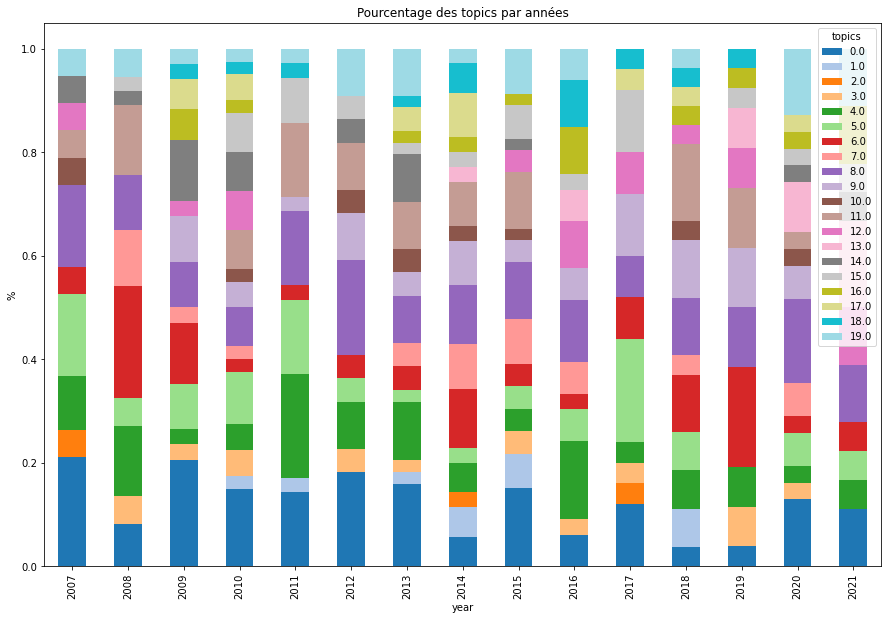

In [247]:
df3.groupby('year').topics.value_counts(normalize=True).unstack().plot(kind='bar', 
                                                                       stacked=True,
                                                                       figsize=(15,10), 
                                                                       legend=True,
                                                                       cmap='tab20',
                                                                       ylabel="%",
                                                                       title="Pourcentage des topics par années",
                                                                          );  #subplots=True, layout=(5, 4), 

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
2007,6.896552,NaN,33.333333,NaN,5.0,8.823529,2.702703,NaN,5.555556,NaN,11.111111,2.777778,5.882353,NaN,5.882353,NaN,NaN,NaN,NaN,3.846154
2008,5.172414,NaN,NaN,14.285714,12.5,5.882353,21.621622,20.0,7.407407,NaN,NaN,13.888889,NaN,NaN,5.882353,5.0,NaN,NaN,NaN,7.692308
2009,12.068966,NaN,NaN,7.142857,2.5,8.823529,10.810811,5.0,5.555556,10.714286,NaN,NaN,5.882353,NaN,23.529412,NaN,14.285714,16.666667,8.333333,3.846154
2010,10.344828,10.0,NaN,14.285714,5.0,11.764706,2.702703,5.0,5.555556,7.142857,11.111111,8.333333,17.647059,NaN,17.647059,15.0,7.142857,16.666667,8.333333,3.846154
2011,8.620690,10.0,NaN,NaN,17.5,14.705882,2.702703,NaN,9.259259,3.571429,NaN,13.888889,NaN,NaN,NaN,15.0,NaN,NaN,8.333333,3.846154
2012,6.896552,NaN,NaN,7.142857,5.0,2.941176,2.702703,NaN,7.407407,7.142857,11.111111,5.555556,NaN,NaN,5.882353,5.0,NaN,NaN,NaN,7.692308
2013,12.068966,10.0,NaN,7.142857,12.5,2.941176,5.405405,10.0,7.407407,7.142857,22.222222,11.111111,NaN,NaN,23.529412,5.0,7.142857,16.666667,8.333333,15.384615
2014,3.448276,20.0,33.333333,NaN,5.0,2.941176,10.810811,15.0,7.407407,10.714286,11.111111,8.333333,NaN,9.090909,NaN,5.0,7.142857,25.000000,16.666667,3.846154
2015,12.068966,30.0,NaN,14.285714,5.0,5.882353,5.405405,20.0,9.259259,7.142857,11.111111,13.888889,11.764706,NaN,5.882353,15.0,7.142857,NaN,NaN,15.384615
2016,3.448276,NaN,NaN,7.142857,12.5,5.882353,2.702703,10.0,7.407407,7.142857,NaN,NaN,17.647059,18.181818,NaN,5.0,21.428571,NaN,25.000000,7.692308


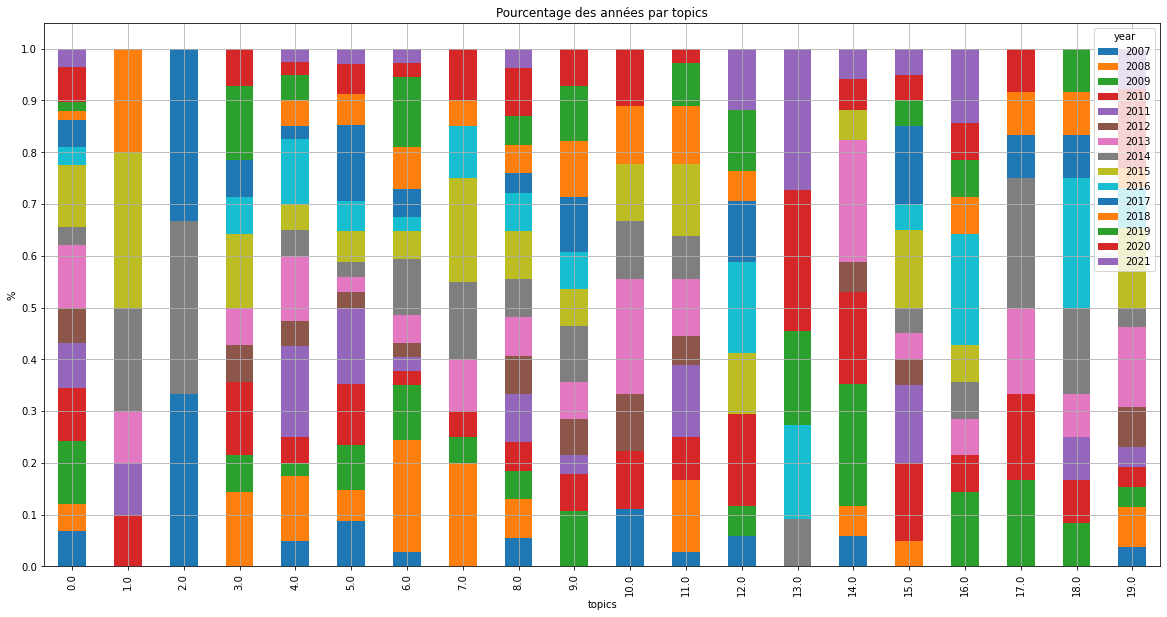

In [244]:
df3.groupby('topics').year.value_counts(normalize=True).unstack().plot(kind='bar', 
                                                                       stacked = True,
                                                                       figsize=(20,10), 
                                                                       legend=True, 
                                                                       grid=True,
                                                                       ylabel="%",
                                                                       title="Pourcentage des années par topics"
                                                                       ); #subplots=True, layout=(4,5),colormap='Spectral'
ax2 = df3.groupby('topics').year.value_counts(normalize=True).mul(100).unstack()
plt.yticks(np.arange(0, 1.1, 0.1));

#Spectral
#rainbow
#prism

tab2 = {}

for idx in ax2.index:
    test2 = []
    for i in ax2:
        test2.append(ax2[i].loc[idx])
    test2.append(sum(ax2.loc[idx].dropna()))
    tab2[idx] = test2
tab2 = pd.DataFrame(tab2)
tab2.transpose()
tab2.index = [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 'Total']
tab2

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


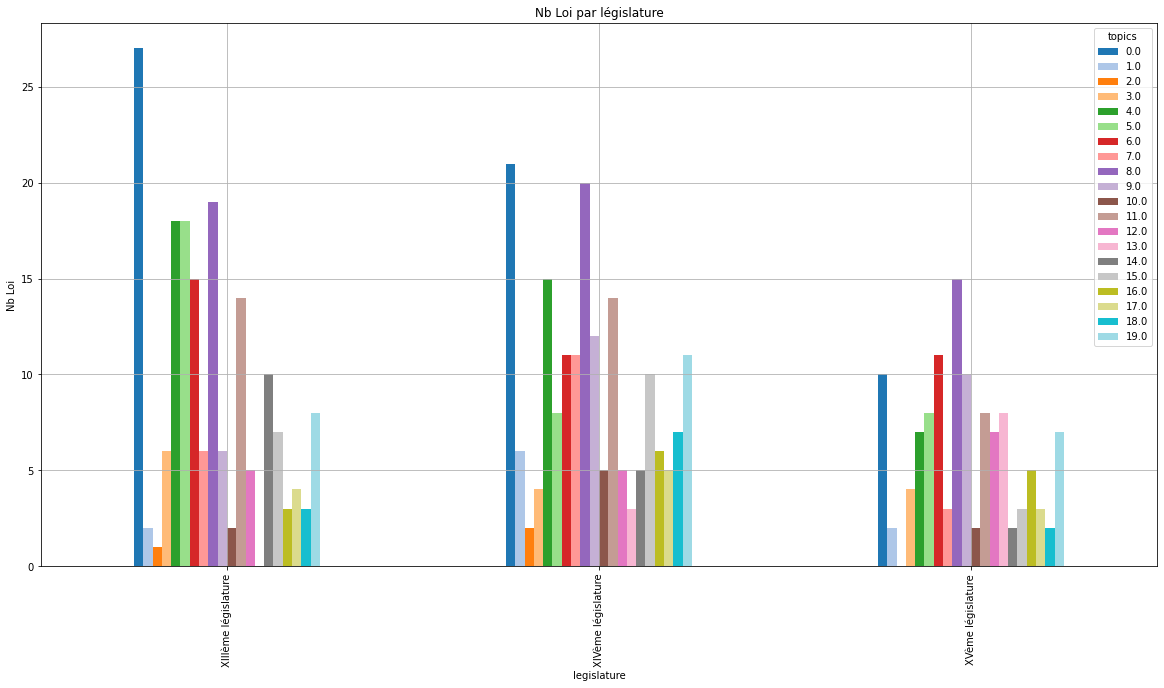

In [248]:
df3.groupby('legislature').topics.value_counts().unstack().plot(kind='bar', 
                                                                        figsize=(20,10),
                                                                        cmap='tab20',
                                                                        grid=True,
                                                                        ylabel="Nb Loi",
                                                                        title="Nb Loi par législature"
                                                                            ); #subplots=True, layout=(5,4),

In [272]:
df3.legislature.value_counts()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


XIVème législature     181
XIIIème législature    174
XVème législature      117
Name: legislature, dtype: int64

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


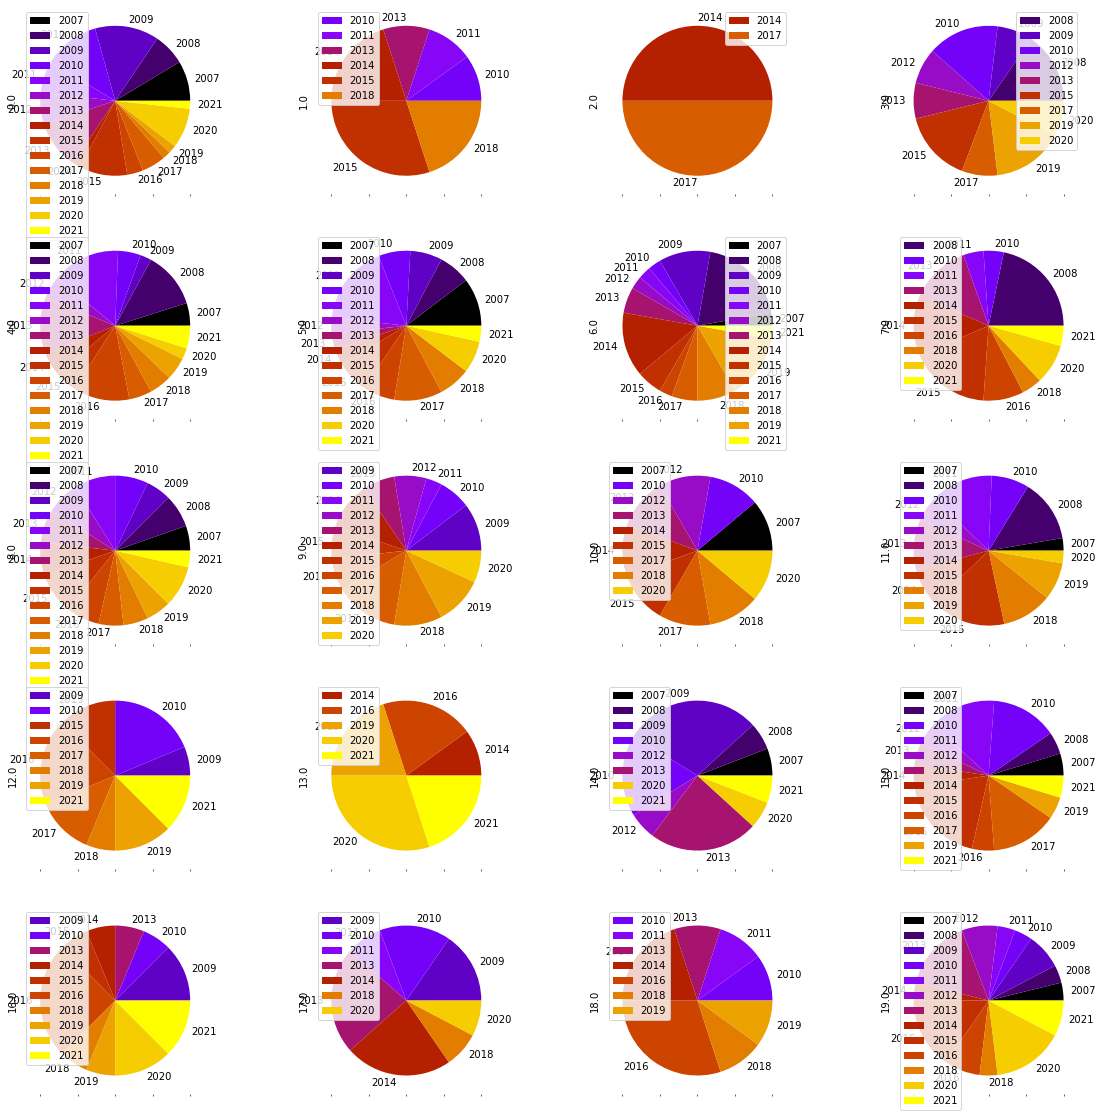

In [501]:
df3.groupby(['year']).topics.value_counts().unstack().plot(kind='pie', figsize=(20,20), subplots=True, layout=(5,4), colormap='gnuplot');
#area
#pie

# Visualisation topic par phrases

In [26]:
senttop = df_dominant_topic_novoid
senttop['year'] = ['' for i in range(len(senttop))]
senttop['legislature'] = ['' for i in range(len(senttop))]

for line in df_dominant_topic_novoid.index:
    senttop['year'].loc[line] = df3.year.loc[tmp[line]]
    senttop['legislature'].loc[line] = df3.legislature.loc[tmp[line]]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-26-7b3407811544>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  senttop['year'] = ['' for i in range(len(senttop))]
<ipython-input-26-7b3407811544>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


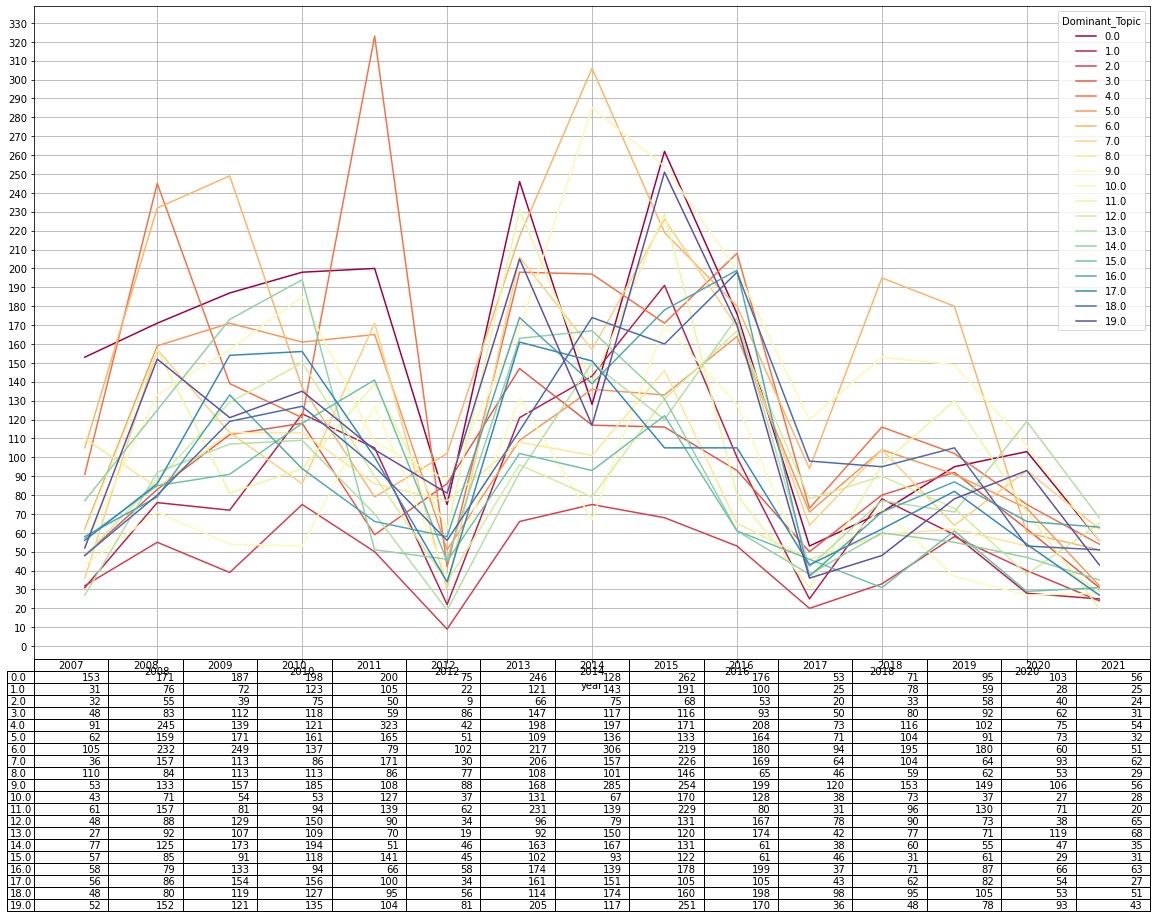

In [237]:
senttop.groupby('year').Dominant_Topic.value_counts().unstack().plot(kind='line', 
                                                                     subplots=False, 
                                                                     figsize=(20,12), 
                                                                     legend=True, 
                                                                     cmap='Spectral',
                                                                     grid=True,
                                                                     table=True,
                                                                        );
plt.yticks(np.arange(0, 340, 10));

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


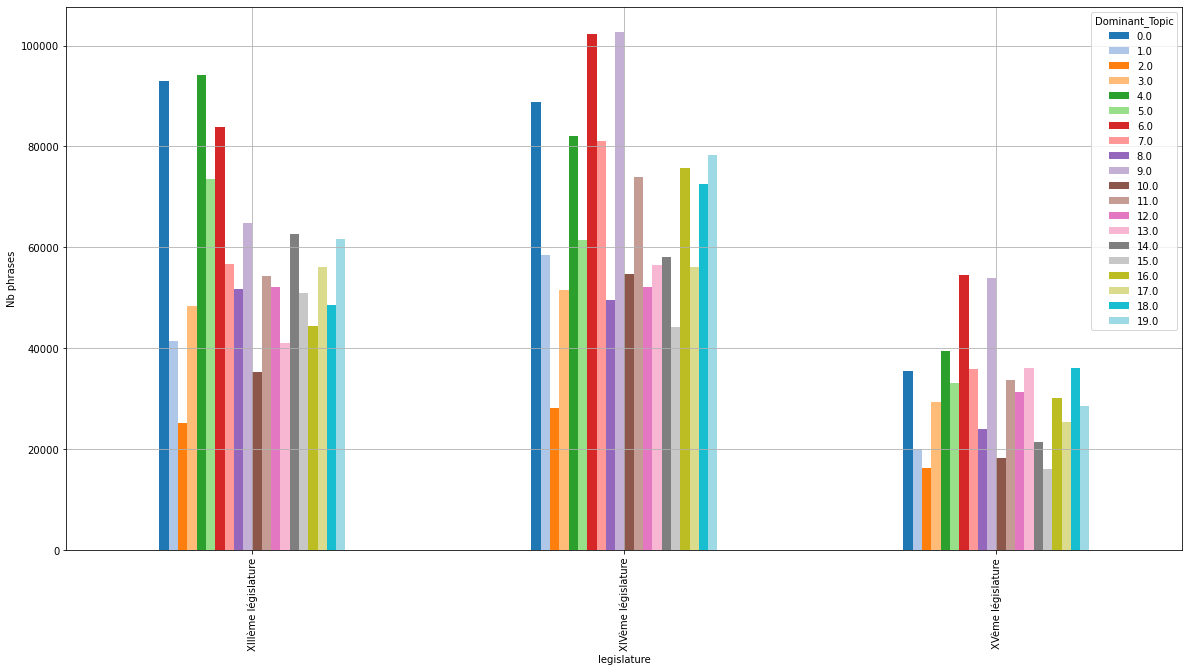

In [209]:
senttop.groupby('legislature').Dominant_Topic.value_counts().mul(100).unstack().plot(kind='bar',
                                                                            #stacked=True,
                                                                            figsize=(20,10),  
                                                                            legend=True,
                                                                            cmap='tab20',
                                                                            ylabel="Nb phrases", 
                                                                            grid=True
                                                                                );

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


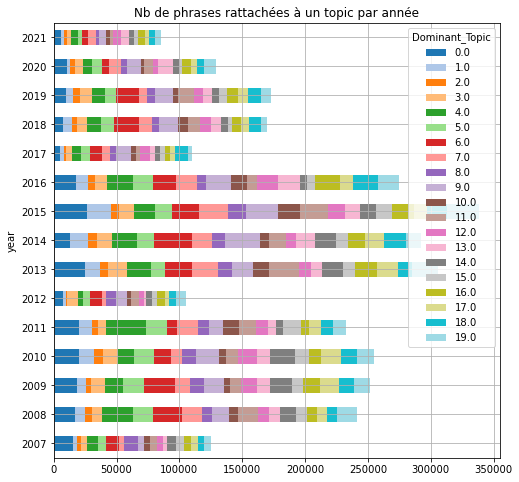

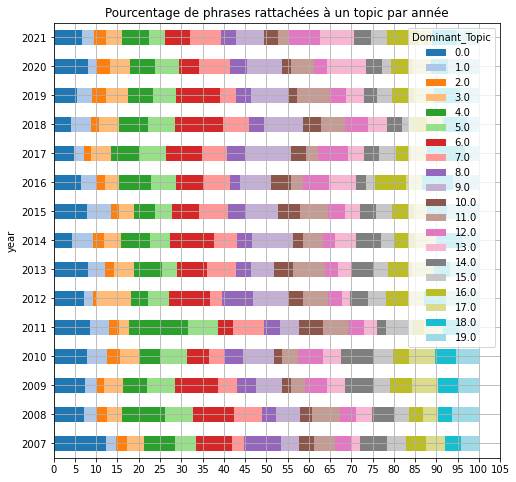

In [270]:
senttop.groupby('year').Dominant_Topic.value_counts().mul(100).unstack().plot(kind='barh',
                                                                                   stacked=True,
                                                                                   #subplots=True, 
                                                                                   figsize=(8,8), 
                                                                                   #layout=(4,5), 
                                                                                   legend=True, 
                                                                                   colormap='tab20',
                                                                                   grid=True,
                                                                                   ylabel="Nb de phrase",
                                                                                   title="Nb de phrases rattachées à un topic par année");

senttop.groupby('year').Dominant_Topic.value_counts(normalize=True).mul(100).unstack().plot(kind='barh',
                                                                                   stacked=True,
                                                                                   #subplots=True, 
                                                                                   figsize=(8,8), 
                                                                                   #layout=(4,5), 
                                                                                   legend=True, 
                                                                                   colormap='tab20',
                                                                                   grid=True,
                                                                                   ylabel="%",
                                                                                   title="Pourcentage de phrases rattachées à un topic par année");
#plt.yticks(np.arange(0, 100, 5))
plt.xticks(np.arange(0, 110, 5));

In [27]:
senttop.legislature.value_counts()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


XIVème législature     13285
XIIIème législature    11403
XVème législature       6194
Name: legislature, dtype: int64

# TEST - Collocations en fonction de l'année

On peut choisir des topics en particulier, mais nous travaillons ici sur tous les topics

In [28]:
senttop2 = senttop

for idx in senttop2.index:
    text = str(senttop2.Text.loc[idx])
    text = re.sub('\[', '', text)
    text = re.sub('\]', '', text)
    text = re.sub('\'', '', text)
    senttop2.Text.loc[idx] = text
senttop2

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:5: DeprecationWarning: invalid escape sequence \[
<>:6: DeprecationWarning: invalid escape sequence \]
<>:5: DeprecationWarning: invalid escape sequence \[
<>:6: DeprecationWarning: invalid escape sequence \]
<ipython-input-28-f06769041f7a>:5: DeprecationWarning: invalid escape sequence \[
  text = re.sub('\[', '', text)
<ipython-input-28-f06769041f7a>:6: DeprecationWarning: invalid escape sequence \]
  text = re.sub('\]', '', text)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,year,legislature
0,0,3.0,0.3475,"établissement, contrat, public, durée, enseign...","France, signer, Paris, accord, agence, spatial...",2015,XIVème législature
1,1,19.0,0.5032,"accord, convention, élection, électoral, trans...","objet, accord, préciser",2015,XIVème législature
2,2,17.0,0.3591,"ministre, modalité, public, présenter, société...","modalité, terrain, CSG, agence, préciser, rela...",2015,XIVème législature
3,3,17.0,0.4346,"ministre, modalité, public, présenter, société...","préciser, engagement, obligation, gouvernement...",2015,XIVème législature
4,4,9.0,0.2523,"social, réforme, économique, secteur, société,...","France, garantir, abord, centre, national, étu...",2015,XIVème législature
...,...,...,...,...,...,...,...
31229,31229,3.0,0.3128,"établissement, contrat, public, durée, enseign...","proposer, pérenniser, remboursement, immédiat,...",2010,XIIIème législature
31230,31230,17.0,0.2657,"ministre, modalité, public, présenter, société...","aide, accession, propriété, multiple, fusionne...",2010,XIIIème législature
31231,31231,1.0,0.4435,"aide, champ, développement, aménagement, plan,...","développement, territoire, rural, encourager, ...",2010,XIIIème législature
31232,31232,14.0,0.3513,"financier, retraite, investissement, effort, r...","décider, tirer, conséquence, crise, financier,...",2010,XIIIème législature


In [30]:
import nltk
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tf_vectorizer = CountVectorizer()

law = {}

for year in senttop2.year.sort_values().unique():
    
    law_x = senttop2.Text.loc[senttop2.year == year].values
    topics_x = senttop2.Dominant_Topic.loc[senttop2.year == year].values

    law[year] = law_x

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.tokenize import word_tokenize

for year in law:
    vectorizer = CountVectorizer(max_features=500)
    vectorizer.fit(law[year])
    X = vectorizer.transform(law[year])
    X = X.toarray()
    features = vectorizer.get_feature_names()
    (num_doc, num_f) = X.shape
    
    cloud_labels = features
    cloud_weights = np.sum(X, axis=0)
    dictionary = dict(zip(cloud_labels, cloud_weights)) 
    
    t_freq = np.where(cloud_weights>20)
    index = t_freq[0]
    X_small = X[:,index]
    features_small = np.array(features)[index]
    print(year, X_small.shape)

    (_,num_f_small) = X_small.shape

    print("Nombre de colonnes = mots : " + str(num_f_small))
    
    co_occ = np.matmul(X_small.transpose(), X_small)

    cooc_secu = []

    for i in range(len(features_small)):
        id_mot = np.where(features_small == features_small[i])[0][0]
        scores_coocc = co_occ[id_mot,:]
        dico_co_occ = dict(zip(features_small, scores_coocc))
        mots_coocc = sorted(dico_co_occ.items(), key=lambda kv: kv[1], reverse=True)
    
#        if mots_coocc[1][1] > 2:
#        if features_small[i] == "sécurité":# or features_small[i] == "lutte" or features_small[i] == "protection":
#            print("[{}] apparaît le plus avec {}".format(features_small[i], mots_coocc[0:30]))
#            for mot in mots_coocc[0:50]:
#                cooc_secu.append(mot)
    
    words = [w.lower() for xpo in law[year] for w in word_tokenize(xpo) if w.lower() != ',']

    for i, word in enumerate(words):
        words[i] = re.sub('\[', "", word)
        words[i] = re.sub('\]', "", word)
    
    bcf = BigramCollocationFinder.from_words(words)
    colloc = bcf.nbest(BigramAssocMeasures.likelihood_ratio, 10)
    bgm = nltk.collocations.BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(words)
    scored = bcf.score_ngrams(bgm.likelihood_ratio)
    #likelihood_ratio  #raw_freq
    
    for i, couple in enumerate(colloc):
        print(scored[i])

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:46: DeprecationWarning: invalid escape sequence \[
<>:47: DeprecationWarning: invalid escape sequence \]
<>:46: DeprecationWarning: invalid escape sequence \[
<>:47: DeprecationWarning: invalid escape sequence \]
<ipython-input-31-435447182c55>:46: DeprecationWarning: invalid escape sequence \[
  words[i] = re.sub('\[', "", word)
<ipython-input-31-435447182c55>:47: DeprecationWarning: invalid escape sequence \]
  words[i] = re.sub('\]', "", word)


2007 (1248, 178)
Nombre de colonnes = mots : 178
(('polynésie', 'français'), 1061.1364105924742)
(('collectivité', 'territorial'), 403.8138285515203)
(('conseil', 'administration'), 348.6938245504781)
(('trafic', 'influence'), 303.2562483092807)
(('agent', 'public'), 286.9069857416363)
(('propriété', 'intellectuel'), 242.95216247318467)
(('pouvoir', 'achat'), 225.9761501690833)
(('assemblée', 'polynésie'), 221.4145612087455)
(('recette', 'fiscal'), 215.0869662063965)
(('enseignement', 'supérieur'), 211.17739384807618)
2008 (2410, 337)
Nombre de colonnes = mots : 337
(('assurance', 'chômage'), 459.9695805319497)
(('entrée', 'vigueur'), 343.35449611628655)
(('port', 'maritime'), 334.3740502587372)
(('collectivité', 'territorial'), 304.32733948496593)
(('demandeur', 'emploi'), 302.5319476165791)
(('port', 'autonome'), 279.9040001674919)
(('milliard', 'euro'), 263.3856873971757)
(('archive', 'public'), 263.0056253624328)
(('organisme', 'génétiquement'), 260.08293940772563)
(('prévention', 

# Collocation par année, par topics

In [32]:
law_t = {}

for year in senttop2.year.sort_values().unique():
    law[year] = senttop2[['Dominant_Topic', 'year', 'Text']].loc[senttop2.year == year]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [47]:
def colloc_all(law):
    for year in law:
        print(year)
        df_year = law[year]
        for topic in df_year.Dominant_Topic.sort_values().unique():
            vec = df_year.Text.loc[df_year.Dominant_Topic==topic].values
#            print(vec[0])
            vectorizer = CountVectorizer(max_features=500)
            vectorizer.fit(vec)
            X = vectorizer.transform(vec)
            X = X.toarray()
            features = vectorizer.get_feature_names()
            (num_doc, num_f) = X.shape
    
            cloud_labels = features
            cloud_weights = np.sum(X, axis=0)
            dictionary = dict(zip(cloud_labels, cloud_weights)) 
    
            t_freq = np.where(cloud_weights>2)
            index = t_freq[0]
            X_small = X[:,index]
            features_small = np.array(features)[index]
            print(topic, X_small.shape)

            (_,num_f_small) = X_small.shape

            print("Nombre de colonnes =", _," mots : " + str(num_f_small))
    
            co_occ = np.matmul(X_small.transpose(), X_small)

            cooc_secu = []

            for i in range(len(features_small)):
                id_mot = np.where(features_small == features_small[i])[0][0]
                scores_coocc = co_occ[id_mot,:]
                dico_co_occ = dict(zip(features_small, scores_coocc))
                mots_coocc = sorted(dico_co_occ.items(), key=lambda kv: kv[1], reverse=True)
    
            words = [w.lower() for xpo in vec for w in word_tokenize(xpo) if w.lower() != ',']

            for i, word in enumerate(words):
                words[i] = re.sub('\[', "", word)
                words[i] = re.sub('\]', "", word)
    
            bcf = BigramCollocationFinder.from_words(words)
            colloc = bcf.nbest(BigramAssocMeasures.likelihood_ratio, 10)
            bgm = nltk.collocations.BigramAssocMeasures()
            finder = BigramCollocationFinder.from_words(words)
            scored = bcf.score_ngrams(bgm.likelihood_ratio)
                                            #likelihood_ratio  #raw_freq
    
            for i, couple in enumerate(colloc):
                print(scored[i])
            temp = [dico[tops[0]] for tops in ldamodel.get_topic_terms(int(topic))]
            print(topic, ":", temp)
#            print(temp)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:48: DeprecationWarning: invalid escape sequence \[
<>:49: DeprecationWarning: invalid escape sequence \]
<>:48: DeprecationWarning: invalid escape sequence \[
<>:49: DeprecationWarning: invalid escape sequence \]
<ipython-input-47-beeac71b9a7a>:48: DeprecationWarning: invalid escape sequence \[
  words[i] = re.sub('\[', "", word)
<ipython-input-47-beeac71b9a7a>:49: DeprecationWarning: invalid escape sequence \]
  words[i] = re.sub('\]', "", word)


In [60]:
#colloc_all(law_t)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [58]:
def colloc_by_top(law, topic_nb):
    topic = topic_nb
    if topic not in law[2007].Dominant_Topic.unique():
        print("Error")
        return("Error, wrong topic in input")
    for year in law:
        print(year)
        df_year = law[year]
        vec = df_year.Text.loc[df_year.Dominant_Topic==topic].values
#        print(vec[0])
        vectorizer = CountVectorizer(max_features=500)
        vectorizer.fit(vec)
        X = vectorizer.transform(vec)
        X = X.toarray()
        features = vectorizer.get_feature_names()
        (num_doc, num_f) = X.shape
    
        cloud_labels = features
        cloud_weights = np.sum(X, axis=0)
        dictionary = dict(zip(cloud_labels, cloud_weights)) 
    
        t_freq = np.where(cloud_weights>2)
        index = t_freq[0]
        X_small = X[:,index]
        features_small = np.array(features)[index]
        print(topic, X_small.shape)

        (_,num_f_small) = X_small.shape

        print("Nombre de colonnes =", _," mots : " + str(num_f_small))
    
        co_occ = np.matmul(X_small.transpose(), X_small)

        cooc_secu = []

        for i in range(len(features_small)):
            id_mot = np.where(features_small == features_small[i])[0][0]
            scores_coocc = co_occ[id_mot,:]
            dico_co_occ = dict(zip(features_small, scores_coocc))
            mots_coocc = sorted(dico_co_occ.items(), key=lambda kv: kv[1], reverse=True)
    
        words = [w.lower() for xpo in vec for w in word_tokenize(xpo) if w.lower() != ',']

        for i, word in enumerate(words):
            words[i] = re.sub('\[', "", word)
            words[i] = re.sub('\]', "", word)
    
        bcf = BigramCollocationFinder.from_words(words)
        colloc = bcf.nbest(BigramAssocMeasures.likelihood_ratio, 10)
        bgm = nltk.collocations.BigramAssocMeasures()
        finder = BigramCollocationFinder.from_words(words)
        scored = bcf.score_ngrams(bgm.likelihood_ratio)
    #likelihood_ratio  #raw_freq
    
        for i, couple in enumerate(colloc):
            print(scored[i])
        temp = [dico[tops[0]] for tops in ldamodel.get_topic_terms(int(topic))]
        print(topic, ":", temp)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:51: DeprecationWarning: invalid escape sequence \[
<>:52: DeprecationWarning: invalid escape sequence \]
<>:51: DeprecationWarning: invalid escape sequence \[
<>:52: DeprecationWarning: invalid escape sequence \]
<ipython-input-58-c7c7cbbe09de>:51: DeprecationWarning: invalid escape sequence \[
  words[i] = re.sub('\[', "", word)
<ipython-input-58-c7c7cbbe09de>:52: DeprecationWarning: invalid escape sequence \]
  words[i] = re.sub('\]', "", word)


In [61]:
#colloc_by_top(law_t, 19)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
def colloc_by_year(law, year):
    print(year)
    if year not in law.keys():
        print("Error")
        return("Error, wrong year in input")
    df_year = law[year]
    topics = df_year.Dominant_Topic.sort_values().unique()
    for topic in topics:
        vec = df_year.Text.loc[df_year.Dominant_Topic==topic].values
#        print(vec[0])
        vectorizer = CountVectorizer(max_features=500)
        vectorizer.fit(vec)
        X = vectorizer.transform(vec)
        X = X.toarray()
        features = vectorizer.get_feature_names()
        (num_doc, num_f) = X.shape
    
        cloud_labels = features
        cloud_weights = np.sum(X, axis=0)
        dictionary = dict(zip(cloud_labels, cloud_weights)) 
    
        t_freq = np.where(cloud_weights>2)
        index = t_freq[0]
        X_small = X[:,index]
        features_small = np.array(features)[index]
        print(topic, X_small.shape)

        (_,num_f_small) = X_small.shape

        print("Nombre de colonnes =", _," mots : " + str(num_f_small))
    
        co_occ = np.matmul(X_small.transpose(), X_small)

        cooc_secu = []

        for i in range(len(features_small)):
            id_mot = np.where(features_small == features_small[i])[0][0]
            scores_coocc = co_occ[id_mot,:]
            dico_co_occ = dict(zip(features_small, scores_coocc))
            mots_coocc = sorted(dico_co_occ.items(), key=lambda kv: kv[1], reverse=True)
    
        words = [w.lower() for xpo in vec for w in word_tokenize(xpo) if w.lower() != ',']

        for i, word in enumerate(words):
            words[i] = re.sub('\[', "", word)
            words[i] = re.sub('\]', "", word)
    
        bcf = BigramCollocationFinder.from_words(words)
        colloc = bcf.nbest(BigramAssocMeasures.likelihood_ratio, 10)
        bgm = nltk.collocations.BigramAssocMeasures()
        finder = BigramCollocationFinder.from_words(words)
        scored = bcf.score_ngrams(bgm.likelihood_ratio)
    #likelihood_ratio  #raw_freq
    
        for i, couple in enumerate(colloc):
            print(scored[i])
        temp = [dico[tops[0]] for tops in ldamodel.get_topic_terms(int(topic))]
        print(topic, ":", temp)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:51: DeprecationWarning: invalid escape sequence \[
<>:52: DeprecationWarning: invalid escape sequence \]
<>:51: DeprecationWarning: invalid escape sequence \[
<>:52: DeprecationWarning: invalid escape sequence \]
<ipython-input-52-5e9d26d86503>:51: DeprecationWarning: invalid escape sequence \[
  words[i] = re.sub('\[', "", word)
<ipython-input-52-5e9d26d86503>:52: DeprecationWarning: invalid escape sequence \]
  words[i] = re.sub('\]', "", word)


In [62]:
colloc_by_year(law_t, 2020)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2020
0.0 (103, 148)
Nombre de colonnes = 103  mots : 148
(('président', 'république'), 100.93516392579708)
(('responsabilité', 'élargir'), 93.60225336698642)
(('européen', 'déléguer'), 84.24542894675304)
(('procureur', 'européen'), 83.62319519858927)
(('élargir', 'producteur'), 74.86678988006581)
(('principe', 'responsabilité'), 54.423021399646544)
(('parquet', 'européen'), 50.13122074040355)
(('habiliter', 'gouvernement'), 46.74063364796035)
(('el', 'hadj'), 43.44749922810074)
(('hadj', 'omar'), 43.44749922810074)
0.0 : ['conseil', 'président', 'république', 'français', 'pouvoir', 'assemblée', 'organique', 'décision', 'préciser', 'gouvernement']
1.0 (28, 21)
Nombre de colonnes = 28  mots : 21
(('gestion', 'déchet'), 37.12275477114371)
(('véhicule', 'moteur'), 35.30436820251751)
(('lutter', 'contre'), 25.163152170623977)
(('milliard', 'euro'), 25.163152170623977)
(('plan', 'soutien'), 25.163152170623977)
(('soutien', 'secteur'), 19.61797472614459)
(('accessible', 'jusque'), 13.97038934

(('lutte', 'contre'), 154.7792075086697)
(('urgence', 'sanitaire'), 137.41568384252213)
(('épidémie', 'covid'), 95.49851941027086)
(('lutter', 'contre'), 80.13556952797606)
(('responsabilité', 'élargir'), 56.56590004613751)
(('salle', 'spectacle'), 56.56590004613751)
(('élargir', 'producteur'), 56.56590004613751)
(('électrique', 'électronique'), 56.56590004613751)
(('crise', 'sanitaire'), 53.812544711955525)
(('équipement', 'électrique'), 51.56187581075486)
13.0 : ['contre', 'protection', 'sanitaire', 'lutte', 'environnement', 'urgence', 'renforcer', 'crise', 'section', 'viser']
14.0 (47, 81)
Nombre de colonnes = 47  mots : 81
(('milliard', 'euro'), 70.90763245098137)
(('conseiller', 'municipal'), 35.12508828772341)
(('collectivité', 'territorial'), 32.89365277458131)
(('logement', 'opposable'), 31.306003277954538)
(('faire', 'objet'), 30.628870185582745)
(('issu', 'produit'), 28.399900764311123)
(('proprement', 'dire'), 28.040162727047374)
(('scientifique', 'souligner'), 28.0401627270